# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (``fwhm= [4, 8]``) and two different normalization (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

Let's first run the group analysis with the SPM normalized data.

## Imports (SPM12)

First, we need to import all modules we later want to use.

In [12]:
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype.pipeline.engine import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [13]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005',]
mask = "/data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [14]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [15]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [16]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

170929-16:02:17,989 workflow INFO:
	 Generated workflow graph: /output/workingdir/spm_l2analysis/graph.dot.png (graph2use=colored, simple_form=True).


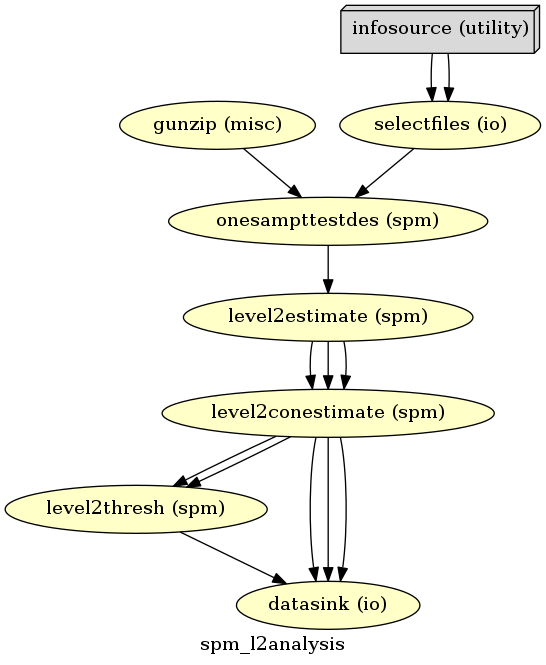

In [17]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.dot.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [18]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

170929-16:02:18,273 workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging']
170929-16:02:18,497 workflow INFO:
	 Running in parallel.
170929-16:02:18,556 workflow INFO:
	 Executing: selectfiles.a9 ID: 0
170929-16:02:18,571 workflow INFO:
	 Executing: selectfiles.a8 ID: 1
170929-16:02:18,583 workflow INFO:
	 Executing node selectfiles.a9 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/selectfiles
170929-16:02:18,620 workflow INFO:
	 Executing: selectfiles.a7 ID: 2
170929-16:02:18,623 workflow INFO:
	 Executing node selectfiles.a8 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/selectfiles
170929-16:02:18,634 workflow INFO:
	 Executing: selectfiles.a6 ID: 3
170929-16:02:18,636 workflow INFO:
	 Executing node selectfiles.a7 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/selectfiles
170929-16:02:18,683 workflow INFO:
	 Executing node selectfiles.a6 in dir: /output/workingdir/spm_l2an

170929-16:07:23,117 workflow INFO:
	 Executing: datasink.a3 ID: 30
170929-16:07:23,328 workflow INFO:
	 Executing node datasink.a3 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/datasink
170929-16:07:23,522 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_8/SPM.mat -> /output/datasink/2ndLevel/spm_con_0002_fwhm8/SPM.mat
170929-16:07:23,558 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_8/spmT_0001.nii -> /output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001.nii
170929-16:07:23,586 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_8/con_0001.nii -> /output/datasink/2ndLevel/spm_con_0002_fwhm8/con_0001.nii
170929-16:07:23,634 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_8/spmT_0001_thr.nii -> /output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii
170929-16:07:23,706 workflow INFO:
	 [Job finished] jobname: datasink.a3 jobid: 30
1

170929-16:10:50,145 workflow INFO:
	 Executing: level2thresh.a6 ID: 44
170929-16:10:50,170 workflow INFO:
	 Executing node level2thresh.a6 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_4/level2thresh
170929-16:10:50,521 workflow INFO:
	 [Job finished] jobname: level2conestimate.a5 jobid: 38
170929-16:10:50,527 workflow INFO:
	 Executing: level2thresh.a5 ID: 39
170929-16:10:50,560 workflow INFO:
	 Executing node level2thresh.a5 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2thresh
170929-16:10:51,818 workflow INFO:
	 [Job finished] jobname: level2conestimate.a7 jobid: 48
170929-16:10:51,820 workflow INFO:
	 Executing: level2thresh.a7 ID: 49
170929-16:10:51,845 workflow INFO:
	 Executing node level2thresh.a7 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/level2thresh
170929-16:11:16,310 workflow INFO:
	 [Job finished] jobname: level2thresh.a4 jobid: 34
170929-16:11:16,313 workflow INFO:
	 Executing: dat

	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/spmT_0001.nii -> /output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001.nii
170929-16:13:38,11 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/con_0001.nii -> /output/datasink/2ndLevel/spm_con_0005_fwhm4/con_0001.nii
170929-16:13:38,22 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/spmT_0001_thr.nii -> /output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii
170929-16:13:38,53 workflow INFO:
	 [Job finished] jobname: datasink.a8 jobid: 55
170929-16:13:47,313 workflow INFO:
	 [Job finished] jobname: level2thresh.a9 jobid: 59
170929-16:13:47,317 workflow INFO:
	 Executing: datasink.a9 ID: 60
170929-16:13:47,354 workflow INFO:
	 Executing node datasink.a9 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/datasink
170929-16:13:47,414 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_8/SPM.mat -> /outpu

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [19]:
# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*_fwhm{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [20]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

And we can run it!

In [21]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 8})
#Changed n_progs from 4 to 8

170929-16:13:48,387 workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging']
170929-16:13:48,573 workflow INFO:
	 Running in parallel.
170929-16:13:48,591 workflow INFO:
	 Executing: selectfiles.a9 ID: 0
170929-16:13:48,604 workflow INFO:
	 Executing: selectfiles.a8 ID: 1
170929-16:13:48,607 workflow INFO:
	 Executing node selectfiles.a9 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0005_fwhm_id_8/selectfiles170929-16:13:48,620 workflow INFO:
	 Executing: selectfiles.a7 ID: 2

170929-16:13:48,623 workflow INFO:
	 Executing node selectfiles.a8 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0005_fwhm_id_4/selectfiles170929-16:13:48,638 workflow INFO:
	 Executing: selectfiles.a6 ID: 3

170929-16:13:48,669 workflow INFO:
	 Executing: selectfiles.a5 ID: 4
170929-16:13:48,643 workflow INFO:
	 Executing node selectfiles.a7 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0004_fwhm_id_8/selectfiles
170929-16:13:48,701 workflow 

170929-16:18:23,330 workflow INFO:
	 Executing: level2conestimate.a7 ID: 48
170929-16:18:23,459 workflow INFO:
	 Executing node level2conestimate.a7 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/level2conestimate
170929-16:18:50,415 workflow INFO:
	 [Job finished] jobname: level2estimate.a0 jobid: 12
170929-16:18:50,419 workflow INFO:
	 Executing: level2conestimate.a0 ID: 13
170929-16:18:50,454 workflow INFO:
	 Executing node level2conestimate.a0 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2conestimate
170929-16:18:54,283 workflow INFO:
	 [Job finished] jobname: level2estimate.a6 jobid: 42
170929-16:18:54,286 workflow INFO:
	 Executing: level2conestimate.a6 ID: 43
170929-16:18:54,348 workflow INFO:
	 Executing node level2conestimate.a6 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_4/level2conestimate
170929-16:18:57,795 workflow INFO:
	 [Job finished] jobname: level2estimate.a5 jobid: 37
170929-16:

170929-16:22:19,914 workflow INFO:
	 Executing node datasink.a6 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_4/datasink
170929-16:22:20,119 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0004_fwhm_id_4/SPM.mat -> /output/datasink/2ndLevel/ants_con_0004_fwhm4/SPM.mat
170929-16:22:20,448 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0004_fwhm_id_4/spmT_0001.nii -> /output/datasink/2ndLevel/ants_con_0004_fwhm4/spmT_0001.nii
170929-16:22:21,102 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_4/con_0001.nii -> /output/datasink/2ndLevel/ants_con_0001_fwhm4/con_0001.nii
170929-16:22:21,814 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0004_fwhm_id_4/con_0001.nii -> /output/datasink/2ndLevel/ants_con_0004_fwhm4/con_0001.nii
170929-16:22:22,473 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_4/spmT_0001_thr.nii -> /output/datasink/2ndLevel/ants_con_

	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/spmT_0001.nii -> /output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001.nii
170929-16:24:51,864 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/con_0001.nii -> /output/datasink/2ndLevel/ants_con_0005_fwhm4/con_0001.nii
170929-16:24:52,312 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_4/spmT_0001_thr.nii -> /output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii
170929-16:24:52,576 workflow INFO:
	 [Job finished] jobname: datasink.a8 jobid: 55
170929-16:24:53,226 workflow INFO:
	 [Job finished] jobname: level2thresh.a9 jobid: 59
170929-16:24:53,229 workflow INFO:
	 Executing: datasink.a9 ID: 60
170929-16:24:53,268 workflow INFO:
	 Executing node datasink.a9 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/datasink
170929-16:24:53,333 interface INFO:
	 sub: /output/datasink/2ndLevel/_contrast_id_con_0005_fwhm_id_8/SPM.mat -> 

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


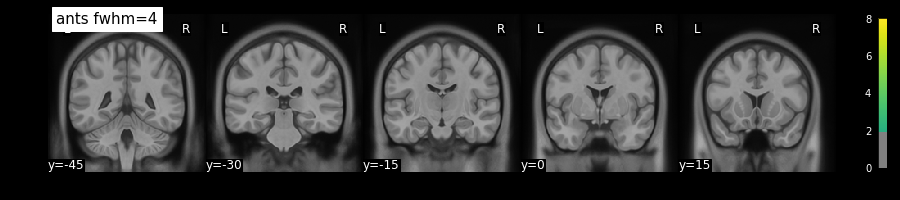

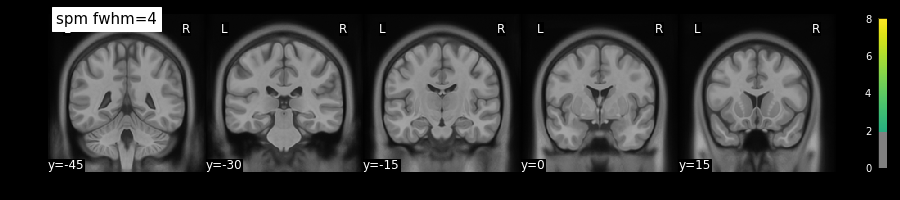

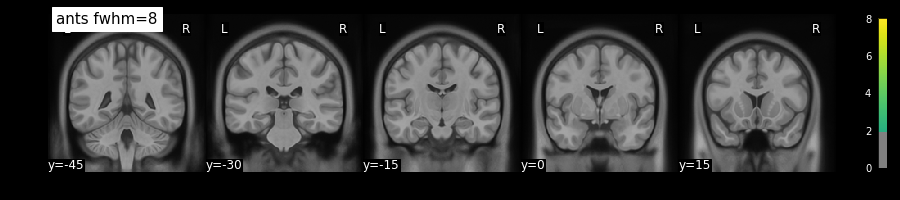

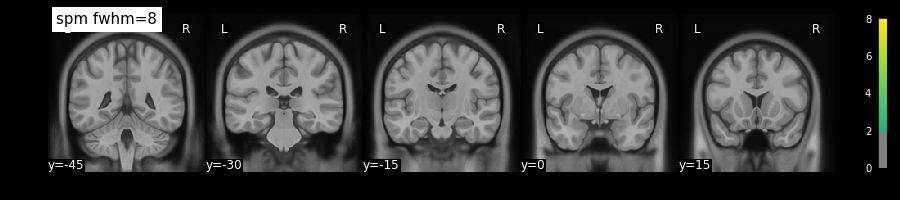

In [22]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8',
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left handed subjects, the activation is seen on the left part of the brain.

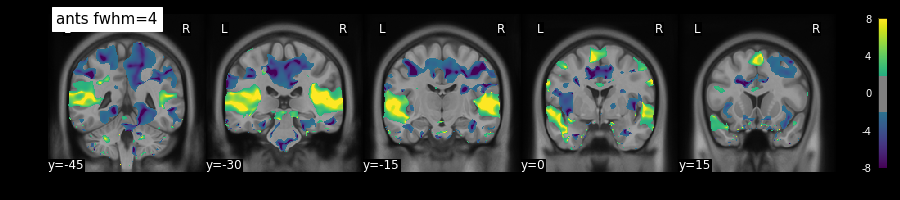

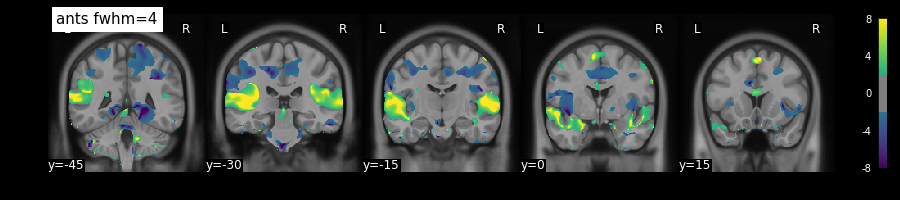

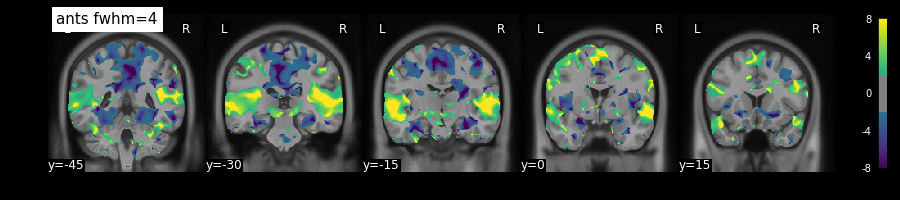

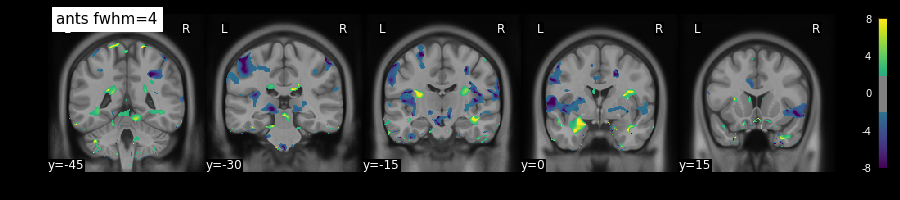

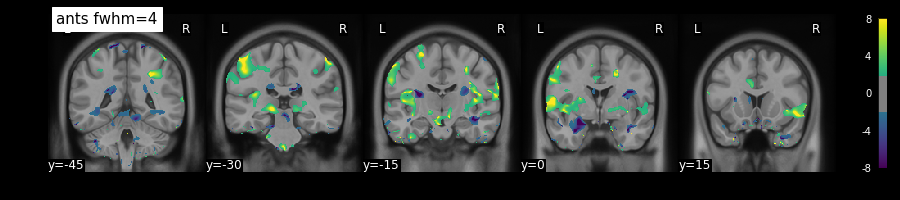

In [23]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0002_fwhm4/spmT_0001.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))


plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0003_fwhm4/spmT_0001.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))


plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0004_fwhm4/spmT_0001.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

#plot_stat_map(
#    '/output/datasink/2ndLevel/spm_con_0002_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
#    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

#plot_stat_map(
#    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
#    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

#plot_stat_map(
#    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8', dim=1,
#    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

Now, let's see the results using the glass brain plotting method.

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


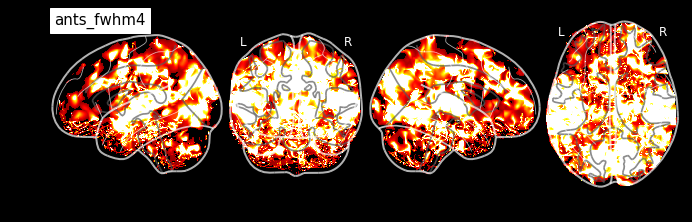

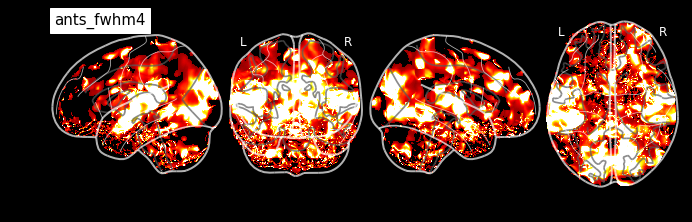

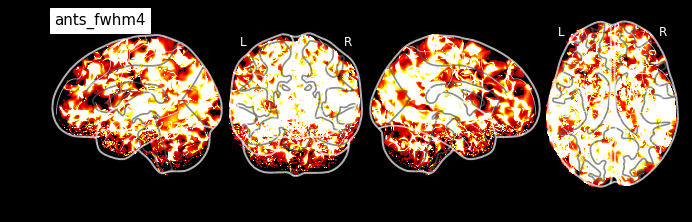

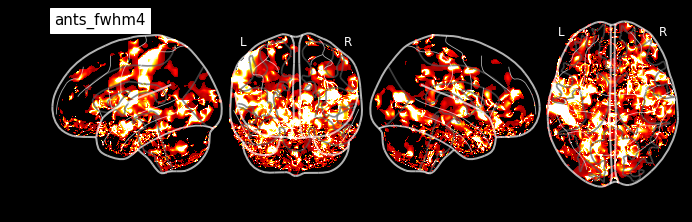

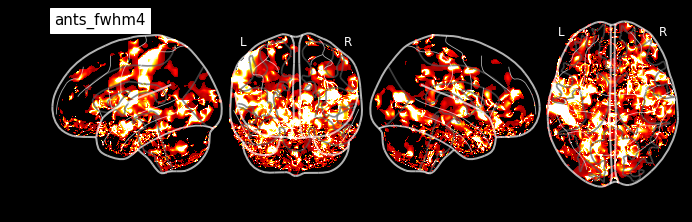

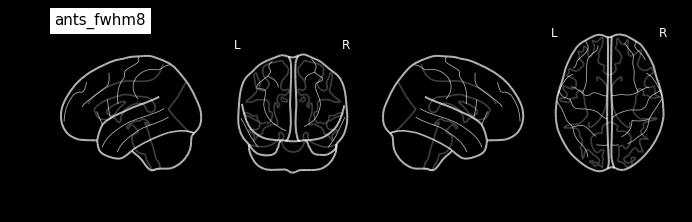

In [24]:
from nilearn.plotting import plot_glass_brain
#plot_glass_brain(
#    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii',
#    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')


plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0002_fwhm4/spmT_0001.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')


plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0003_fwhm4/spmT_0001.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')


plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0004_fwhm4/spmT_0001.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')


plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')


#plot_glass_brain(
#    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii',
#    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0002_fwhm8/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8')